In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import albumentations as A

In [ ]:
# Define function to apply weather effects
def apply_weather_effect(image, effect_type="rain"):
    if effect_type == "rain":
        transform = A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=1)
    elif effect_type == "snow":
        transform = A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1)
    return transform(image=image)['image']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
image_data_dir = "/content/drive/My Drive/CNN/Dataset/train_images"
image_filenames = os.listdir(image_data_dir)
labels_data = pd.read_csv("/content/drive/My Drive/CNN/Dataset/labels.csv")

# Preprocess and separate original and augmented data
original_images = []
augmented_images = []
original_labels = []
augmented_labels = []

for filename in image_filenames:
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image is not None else None
    if image is not None and filename in labels_data['image_filename'].values:
        label = labels_data[labels_data['image_filename'] == filename]['label'].iloc[0]
        original_images.append(image)
        original_labels.append(label)

        # Randomly decide to augment with weather effects
        if np.random.rand() < 0.5:  # 50% chance to augment
            effect_type = np.random.choice(["rain", "snow"])
            aug_image = apply_weather_effect(image, effect_type=effect_type)
            augmented_images.append(aug_image)
            augmented_labels.append(label)

In [ ]:
# Convert lists to arrays
X_original = np.array(original_images)
y_original = to_categorical(np.array(original_labels))
X_augmented = np.array(augmented_images)
y_augmented = to_categorical(np.array(augmented_labels))

# Combine original and augmented for validation and testing
X_combined = np.concatenate((X_original, X_augmented))
y_combined = np.concatenate((y_original, y_augmented))

# Split into training, validation, and test sets
X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(X_original, y_original, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, test_size=0.5, random_state=42)  # Split combined for validation and testing

X_train_aug, _, y_train_aug, _ = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)  # Training set for augmented model

In [ ]:
from tensorflow.keras.applications import ResNet50

# Define the model building function
def create_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=X_train_orig[0].shape)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation=hp.Choice('activation', values=['relu', 'tanh'])),
        Dense(y_train_orig.shape[1], activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        metrics=["accuracy"]
    )
    return model

In [ ]:
from keras_tuner import HyperParameters, BayesianOptimization

# Initialize Bayesian optimization
tuner = BayesianOptimization(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    directory='resnet_tuner',
    project_name='bayesian_search'
)


In [ ]:
# Run the tuner search
tuner.search(X_train_orig, y_train_orig, epochs=10, validation_data=(X_val, y_val))


Trial 10 Complete [00h 00m 55s]
val_accuracy: 0.9293948411941528

Best val_accuracy So Far: 0.9351584911346436
Total elapsed time: 00h 08m 44s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters are:
- Units: {best_hps.get('units')}
- Activation: {best_hps.get('activation')}
- Optimizer: {best_hps.get('optimizer')}
""")


The best hyperparameters are:
- Units: 128
- Activation: relu
- Optimizer: rmsprop



In [ ]:
# Fetch the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Fetch a summary of the trials
trials = tuner.oracle.get_best_trials(num_trials=10)

val_accuracies = [trial.score for trial in trials if trial.score is not None]
trial_ids = [trial.trial_id for trial in trials if trial.score is not None]


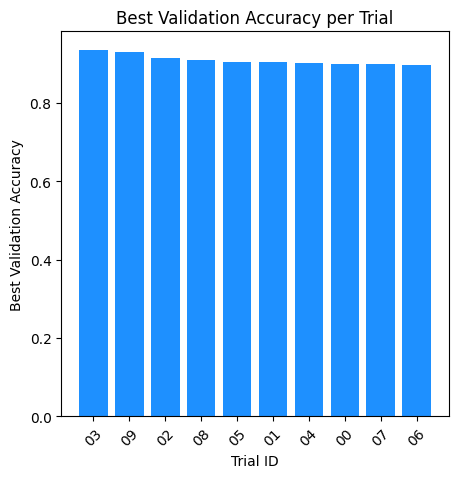

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.bar(trial_ids, val_accuracies, color='dodgerblue')
plt.xlabel('Trial ID')
plt.ylabel('Best Validation Accuracy')
plt.title('Best Validation Accuracy per Trial')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Evaluate the best model on the test set
bayesian_search_score = best_model.evaluate(X_test, y_test, verbose=0)
print("Bayesian Search Model - Test loss:", bayesian_search_score[0], "Test accuracy:", bayesian_search_score[1])

Bayesian Search Model - Test loss: 4.753904819488525 Test accuracy: 0.9351584911346436


In [ ]:
def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
# Create and train baseline model
baseline_model = create_model(X_train_orig.shape[1:], y_train_orig.shape[1])
baseline_history = baseline_model.fit(X_train_orig, y_train_orig, epochs=40, validation_data=(X_val, y_val))


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 546ms/step - accuracy: 0.7831 - loss: 11.6618 - val_accuracy: 0.9135 - val_loss: 12.0802
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9668 - loss: 1.1067 - val_accuracy: 0.9006 - val_loss: 7.9494
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9848 - loss: 0.3313 - val_accuracy: 0.9380 - val_loss: 2.1863
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9937 - loss: 0.0517 - val_accuracy: 0.9035 - val_loss: 5.6140
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9966 - loss: 0.0403 - val_accuracy: 0.9251 - val_loss: 3.2887
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9960 - loss: 0.0435 - val_accuracy: 0.9063 - val_loss: 6.7007
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9941 - loss: 0.2512 - val_accuracy: 0.9236 - val_loss: 4.7507
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9992 - loss: 0.0084 - val_accuracy:

In [ ]:
# Create and train augmented model
augmented_model = create_model(X_train_aug.shape[1:], y_train_aug.shape[1])
augmented_history = augmented_model.fit(X_train_aug, y_train_aug, epochs=40, validation_data=(X_val, y_val))


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7682 - loss: 8.3343 - val_accuracy: 0.9568 - val_loss: 5.1474
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9713 - loss: 1.9355 - val_accuracy: 0.8444 - val_loss: 11.5146
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9622 - loss: 1.4863 - val_accuracy: 0.9640 - val_loss: 4.0116
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9930 - loss: 0.2826 - val_accuracy: 0.9625 - val_loss: 5.2970
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9935 - loss: 0.3956 - val_accuracy: 0.9611 - val_loss: 6.0918
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9982 - loss: 0.0795 - val_accuracy: 0.8934 - val_loss: 11.2960
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9919 - loss: 0.1766 - val_accuracy: 0.9597 - val_loss: 5.9627
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy

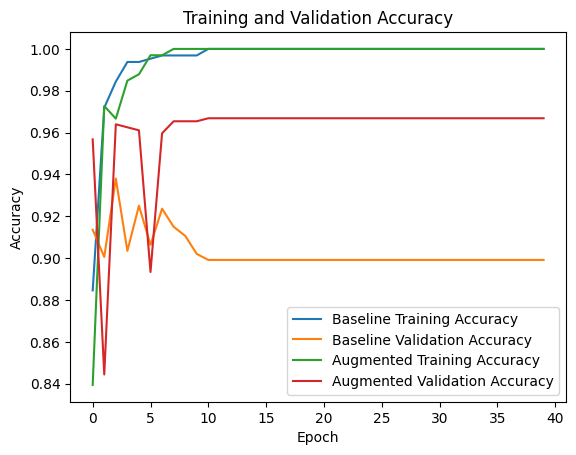

In [ ]:
import matplotlib.pyplot as plt
plt.plot(baseline_history.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.plot(augmented_history.history['accuracy'], label='Augmented Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Augmented Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate both models on the test set
baseline_score = baseline_model.evaluate(X_test, y_test, verbose=0)
augmented_score = augmented_model.evaluate(X_test, y_test, verbose=0)
print("Baseline Model - Test loss:", baseline_score[0], "Test accuracy:", baseline_score[1])
print("Augmented Model - Test loss:", augmented_score[0], "Test accuracy:", augmented_score[1])

Baseline Model - Test loss: 7.7023797035217285 Test accuracy: 0.909221887588501
Augmented Model - Test loss: 9.291404724121094 Test accuracy: 0.9538905024528503


In [ ]:
# Percentage change in test loss
change_loss=((bayesian_search_score[0]-augmented_score[0])/augmented_score[0])*100
print(f"Percentage change in test loss: {change_loss:.2f}%")

# Percentage change in test accuracy
change_acc=((bayesian_search_score[1]-augmented_score[1])/augmented_score[1])*100
print(f"Percentage change in test accuracy: {change_acc:.2f}%")


Percentage change in test loss: -48.84%
Percentage change in test accuracy: -1.96%
